#### model domain : single stream
### chemsitry: radioactive decay
### bondary condition
### initial condition

In [1]:
#************************* MAIN SCRIPT **********************************
import sys, os, math, h5py, csv
import matplotlib.pyplot as plt
from scipy import integrate
import numpy as np

#sys.path.append('/Users/ajc/Core/PreProcessing/PyScript') #this should be append ats tools,
#import readdata

sys.path.append('/Users/ajc/Core/codes/simulator/debug/ats/tools/utils')
import read_helper as read

In [6]:
#path of the simulation directory
path = '/Users/ajc/FUSE/simulations/tests/ats-demos/13_reactive_transport/01_stream'
#path = '/Users/ajc/FUSE/simulations/tests/ats-demos/13_reactive_transport/04_hyporheic'
path1 ='/Users/ajc/FUSE/simulations/tests/ats-regression-tests/07_reactive_transport/'


In [7]:
# Read PFOTRAN standalone data
pflotran_file = os.path.join(path, 'data/pflotran_out/decay_ingrowth.tec')
pflotran_data = dict()
pflotran_data['time'] = np.loadtxt(pflotran_file,usecols=0,skiprows=6) #time in hours
pflotran_data['Tracer 1'] = np.loadtxt(pflotran_file,usecols=1,skiprows=6)  # Tracer 1
pflotran_data['Tracer 2'] = np.loadtxt(pflotran_file,usecols=2,skiprows=6)  # Tracer 1

In [12]:
F= ['prun2']
F =['test']
Files = [os.path.join(path1,f,'visdump_surface_data.h5') for f in F]
vars = ['surface-total_component_concentration', 'surface-total_component_concentration']
Suffix = ['.cell.Tracer1 conc', '.cell.Tracer2 conc']


In [13]:
Colors = ['r','k','b','b','c','m']
Colors_sg = ['r','k','g','m']
F_L = ['Tracer 1', 'Tracer 2']

In [16]:
#%matplotlib tk
def plot_surface_outlet(cell_id=-1):
    fig, axs = plt.subplots(1,1, figsize=(6,4), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)
    plt.tight_layout()
    #axs = axs.ravel()
    
    sum1 = 0
    for i, v in enumerate(vars):
        plt.subplot(111)
        for j,f in enumerate(Files):
            data = np.array(read.GetSurfVarFromVis(f,v,cellid=cell_id,suffix=Suffix[i])[v])
            Time = np.array([240*i/3600. for i in range(len(data))])
            plt.plot(Time, 1.e-3*data,color=Colors[i],label=F_L[i]) # convert ATS moles/second to Pflotran moles/litre
            sum1 = sum1 + 1e-3*data[-1]
        plt.ylabel(vars[i])

        plt.xlabel('Time [h]')

    plt.plot(pflotran_data['time'], pflotran_data['Tracer 1'],'r',linestyle='--',label='PFLOTRAN Tracer 1')
    plt.plot(pflotran_data['time'], pflotran_data['Tracer 2'],'k',linestyle='--',label='PFLOTRAN Tracer 2')
    plt.legend(loc='lower right',fontsize=10)
    #plt.xlim(0,8)
    plt.show()

/Users/ajc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


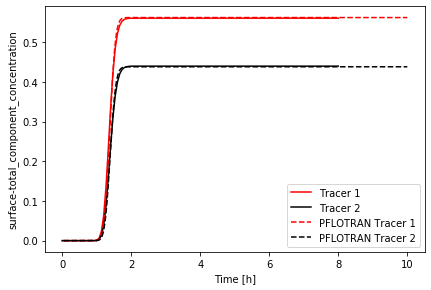

In [17]:
plot_surface_outlet(cell_id=49)

In [ ]:
def subgrid_C(sg_file,sg_var, suff):
        sgC_data = readdata.GetSurfVarFromVis_All(sg_file,sg_var,suffix=suff)
        sgConcentration = sgC_data[sg_var]
        return sgConcentration
    
def plot_surface_subgrid(ncells=-1):
    fig, axs = plt.subplots(1,3, figsize=(14,4), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)
    plt.tight_layout()
    
    sum1 = 0
    
    for i, v in enumerate(vars):
        plt.subplot(131)

        dat1 = np.array(readdata.GetSurfVarFromVis(Files[0],v,cellid=ncells,suffix=Suffix[0])[v])
        dat2 = np.array(readdata.GetSurfVarFromVis(Files[0],v,cellid=ncells,suffix=Suffix[1])[v])
        data = dat1 + dat2
        Time = np.array([900*i/3600. for i in range(len(data))])
        if i ==0:
            plt.plot(Time, 1.e-3*data,color=Colors[2],label='total concent. %s'%(np.round(1e-3*data[-1],5)))
        plt.plot(Time, 1.e-3*dat1,color=Colors[0],label='%s: %s'%(F_L[0],np.round(1e-3*dat1[-1],5)))
        plt.plot(Time, 1.e-3*dat2,color=Colors[1],label='%s: %s'%(F_L[1],np.round(1e-3*dat2[-1],5)))
        sum1 = sum1 + 1e-3*data[-1]
        print ('surface:', sum1, 1e-3*data[-1])
        plt.ylabel(vars[i])

        plt.xlabel('Time [h]')
        plt.title('stream outlet, x = %s'%ncells)
        plt.legend()
        break
    plt.subplot(132)
    xnum = 100
    R = [0, ncells]

    n_taus = 20
    for i,x1 in enumerate(R):

        sg_infile = os.path.join(path,F[0],'visdump_subgrid_%s_data.h5'%x1)
        sg_var='subgrid_%s-total_component_concentration'%x1

        dat1 = subgrid_C(sg_file=sg_infile,sg_var=sg_var, suff=Suffix[0])
        dat2 = subgrid_C(sg_file=sg_infile,sg_var=sg_var, suff=Suffix[1])

        if (i ==1):
            dat11a = 1e-3*np.reshape(dat1,(-1,n_taus))
            dat11b = [d[0] for d in dat11a] #first cell in Tau space
            dat11c = [d[-1] for d in dat11a] # last cell in Tau space
            
            plt.plot(Time, dat11b,'-',color=Colors_sg[i-1],label='sg_%s[0]_Tc1 =%s)'%(R[i],np.round(dat11b[-1],4)))
            plt.plot(Time, dat11c,'-',color=Colors_sg[i],label='sg_%s[19]_Tc1 = %s)'%(R[i],np.round(dat11c[0],4)))


            dat21a = 1e-3*np.reshape(dat2,(-1,n_taus))
            dat21b = [d[0] for d in dat21a]
            dat21c = [d[-1] for d in dat21a]
            
            plt.plot(Time, dat21b,'-',color=Colors_sg[i+1],label='sg_%s[0]_Tc2 = %s)'%(R[i],np.round(dat21b[-1],4)))
            plt.plot(Time, dat21c,'-',color=Colors_sg[i+2],label='sg_%s[19]_Tc2 = %s)'%(R[i],np.round(dat21c[0],4)))

    plt.title('subgrid. Tracer 1 and 2 at sg_cell 0')
    plt.legend(loc='best', fontsize=9)
    plt.subplot(133)
    
    for i,x1 in enumerate(R):

        sg_infile = os.path.join(path,F[0],'visdump_subgrid_%s_data.h5'%x1)
        sg_var='subgrid_%s-total_component_concentration'%x1
        dat1 = subgrid_C(sg_file=sg_infile,sg_var=sg_var, suff=Suffix[0])#[-1][::-1]
        dat2 = subgrid_C(sg_file=sg_infile,sg_var=sg_var, suff=Suffix[1])#[-1][::-1]

        if (i ==1 or i ==0):
            dat11a = 1e-3*np.reshape(dat1,(-1,n_taus))
            dat11 = dat11a[-1]
            
            dat21a = 1e-3*np.reshape(dat2,(-1,n_taus))
            dat21 = dat21a[-1]
            
            plt.plot(dat11,'*',color=Colors_sg[i],label='sg_%s  (Tc1. %s)'%(x1,np.round(np.max(dat11),4)))
            plt.plot(dat21,'.',color=Colors_sg[i],label='sg_%s  (Tc2. %s)'%(x1,np.round(np.max(dat21),4)))
            plt.xlabel('# cells in Tau space')
        
    plt.title('subgrid')


    plt.legend(loc='best', fontsize=9)
    plt.show()


In [ ]:
plot_surface_subgrid(ncells=9)

In [ ]:
What is your criterea for mcmc convergence

Different initial values for parameters

Predictive uncertainty.

Did you pick all data from location 3 – are you matching 

Instead of using just one observed tracer, did you try 

Adam ward 2016


In [ ]:
there is no reason to believe it will not work
I will echo your comment
We are working with one data set, but are not marry to it

we could not do it without your help

there will be bumps along the road

research has shown groundwater is an important link to the lower atmosphere.  
Both projects seem like a great opportunity to study this— are there plans for this?

his video is off to converse bandwidth
reduce fregmentation